# Random walk on a Random invironment

Let $\mathbb{Z}$ be the set of integers, we are goint to define a **Simple Exclusion Process** $X_t$ on $\mathbb{Z}$ in order  to define a random environment and above that another particle will do **Random walk** over this random environment.

In time $t=0$ for each $i \in \mathbb{Z}$ is drawn independently from a Bernoulli $\frac{1}{2}$ distribution to define if there is a particle in position $i$ or if there is no particle in that place. When times passes from $t=0$ to $t=1$, the environment changes with the following rule.

- $s$ is draw from a *Poisson* distribution of mean $v$ (v menas the velocity of the environment).
- $s$ particles are chosen (with reposition) to move, the order that we chose the particles to move matters.
- For each particle *to move*, if the postion of the particle is $i$ then the new position of that particle is $i-1$ or $i+1$ with the same probability, but the particle only moves to that new postion with there is no other particle occuping the same space.

Between the interchanges of the environment it is done a (discrete) **Random walk**.

- The random walk starts at position $0$.
- If the random walk is in a position where there is a particle, then the random walk has a *right drift*, that means the probability of the random walk to go to the right neighbor is $2/3$ and the probability to go to the left neighbor is $1/3$.
- Otherwise the random walk is in a position without particle and there is a *left drift*, that means the probabilty to go to left is $2/3$ and the probability to go the right is $1/3$.

Remark: the random walk does no affect the moviment of the environment particles,

The main goal of the following code is to simulate an box of this process and try to estimate the coefficient of diffusion of this process.

Is somehow believied that $\mathbb{E}|X_t|\sim a_0 n^\gamma$, we call this coefficient $\gamma$ *coefficient of diffusion*.

**Update:**

In the last version I was sampling the (random) environment as a sequence of (L) zeros and ones (one means particle and zero means no particle).
Now I gonna sample differently, sample a vector(named 'space_env') with (lenght = L/2) indexes (sorted increasing), for each index(e.g. space_ev = [0,1,4,7,9,10] ) in that vector meant to has a particle in that location (e.g. the first particle is at position 0 and last one is at position 10)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy.stats import bernoulli

# random.seed(168)

#defining parameters

L = 10      # number of size space simulated
mu = 1/2    # proportion of environment particles


def space_env(L , mu):
    total_space = np.arange(L)
    space = np.random.choice(total_space, int(L/2), replace=False)  # choose L/2 of the bins to contain a particle
    return(np.sort(space))                                          # return the index of the particles sorted

test = space_env(L,mu)
print(test)

[1 2 5 7 8]



The function bellow tells how the particle moves, and takes as input `space`, an *sorted increasing* array of particle positions and updates the positions of the particles according with the particle movements.

**Remark:** the output of `move_particle` is always a cyclical permutation of a *sorted increasing* array (not necessarily the input one).

In [2]:

def move_particle(space, s):
    #Moves s particles to a neighboring site if that new position is empty
    L = int(2*len(space))
    particles_index = np.arange(int(L/2))
    particles_to_move = np.random.choice(particles_index,s)
    
    # Pick a random direction  for each step (left or right)
    direction = np.random.choice([-1, 1], s)
    
    # this is a torus, if the particle at L-1 jumps to right it goes to 0, and vice-versa
    for idx_atual, dir_particle in zip(particles_to_move, direction):
        # Check if the new position is empty (no particle present)
        # Since we are in Z, the order of partiles is never changed, 
        # therefore it's enough to check if new_postition is equal to position of next particle.
        if ((space[idx_atual] + dir_particle)% L  ) != ((space[(idx_atual + dir_particle)%(int(L/2))])%L):
            # Move the particle
            space[idx_atual] = (space[idx_atual] + dir_particle)%L

space = space_env(8, 1/2)
print(space)
move_particle(space, 8)
print(space)




[0 1 5 6]
[0 1 3 6]


The next function takes as input `(space,a)`
- `space` is the array of integers containing the positions of all environment particles.
- `a` is an integer representing a position oof the space

The output of `search_in_totated_array(space,a)` is a boolean that answers if `a`belong to `space` or not. 
It's  an adaptation of binary search on a sorted list, it only works, because `space`it is not a sorted list, but it is a cyclic permutation of a sorted list, and this only happens in dimension one.


In [5]:
def search_in_rotated_array(space, a)-> bool: # This is an adaptation of binary search that decides wheter a belongs to space or not
    left, right = 0, len(space) - 1 

    while left <= right:
        mid = (left + right) // 2

        if space[mid] == a:
            return True  # Found the element

        # Determine which side is properly sorted
        if space[left] <= space[mid]:  # Left half is sorted
            if space[left] <= a < space[mid]:  # Target in left half
                right = mid - 1
            else:  # Target in right half
                left = mid + 1
        else:  # Right half is sorted
            if space[mid] < a <= space[right]:  # Target in right half
                left = mid + 1
            else:  # Target in left half
                right = mid - 1

    return False  # Element not found

L=10
space = space_env(L, 1/2)
rw = np.random.choice(np.arange(L))
print(space)
print(rw)
print(search_in_rotated_array(space,rw))

[0 1 6 7 8]
1
True


In [ ]:

'''Random Walk'''


def random_walk_step(space , rw , right_drift, left_drift):
    
    if search_in_rotated_array(space,rw): # in blue particles there is a right shift
        direction = bernoulli.rvs(right_drift)  # sample 1 with prob 1/3 and 0 with probability 2/3 
        direction = 2*direction -1              # change bernoulli(0,1) to bernoulli(-1,+1)
        rw = rw + direction
        # print(direction)
        return(rw)
    
    else :# in red particles there is a left shift
        direction = bernoulli.rvs(left_drift)   # sample 1 with prob 2/3 and 0 with probability 1/3 
        direction = 2*direction -1              # change bernoulli(0,1) to bernoulli(-1,+1)
        rw = rw + direction
        # print(direction)
        return(rw)


def random_walk(L,v,t,mu , right_drift, left_drift): 
    # L means size of lattice,
    # v is the velocity of the environment particles, 
    # t is the number of steps of RW, 
    # mu is the proportion of particlesin the environment.

    rw = 0 # random walk starts at zero
    
    space = space_env(L, mu)
    # print(space)
    numb_particle = len(np.where(space)[0])

    for t0 in range(t):
        s = np.random.poisson(numb_particle*v)

        move_particle(space , s)
        rw = random_walk_step(space,rw,right_drift,left_drift)
    return(rw)

rw = random_walk(20, 1, 10 , 0.5 , 2/3 , 1/3)
print(rw)


-2


In [68]:

def generate_data(Numbsimul,L,v,t,mu,right_drift,left_drift):
    # L,v,t,mu  are exactly thte same parameters used in random_walk
    # N is the number of simulations made
    # data = []
    # for i in range(Numbsimul):
    #     data.append(random_walk(L,v,t,mu))
    data = np.array([random_walk(L,v,t,mu,right_drift,left_drift) for i in range(Numbsimul)])
    return(data)


# data = generate_data(150 , 50 , 1 , 50, 0.5)
# print(data)
# import time



def full_data_random_walk(k1,k2,Numbsimul,v,mu,right_drift,left_drift):
# k_1 is the minum size simulation and k2 is biggest 
    if k2<=k1:
        print('------------k2 must be bigger than k1-----------')
        return('error')

    start_time = time.time()


    # progress_bar(-k1, k2-k1-1, prefix='Progress:', suffix = k2, length=30)
    # (L,v,t,mu) are exactly the same parameters used in random walk
    

    data = np.zeros((k2+1-k1, Numbsimul))

    for i, k in tqdm(enumerate(range(k1, k2+1))):
        n = pow(2,k)
        data[i,:] = np.array(generate_data(Numbsimul,n,v, n,mu,right_drift,left_drift))
        #print(data_for_n)
        #data.append(data_for_n)
        #progress_bar(k, k2, prefix='Progress:', suffix = k2, length=30)
    print('\n')
    print("--- %s seconds ---" % (time.time() - start_time))

    return(data)

A = full_data_random_walk(3,6, 10, 1,0.5,1/3,2/3)
print(A)


4it [00:00, 45.93it/s]



--- 0.08912134170532227 seconds ---
[[ 0.  0.  0.  0.  0.  2.  0.  0.  2.  2.]
 [ 0. -2. -4.  0.  2.  0.  0. -4.  2.  2.]
 [ 0.  2.  6. -2.  4. -2. 12.  6.  2.  2.]
 [ 2.  0.  0.  0. -6.  0.  8.  4. 12.  2.]]


In [61]:


# taking absolute value of S_n, sorting the samples, calculate mean and median.
def treat_this_data(A):
    absA = np.abs(A)
    sortedAbs = np.sort(absA)
    meanA = absA.mean(1)
    median = np.quantile(absA, 0.5 , 1)
    return (absA,sortedAbs,meanA, median)



k1 = 9
k2 = 10

A = full_data_random_walk(k1,k2, 125, 1,0.5,1/3,2/3)

# Size = np.linspace(k1,k2, k2-k1+1)
# linear_regression(0.5,Size,A)

2it [00:44, 22.10s/it]



--- 44.19863557815552 seconds ---


In [62]:

import scipy
from scipy.stats import norm


# random.seed(1998)

# calculating the interval of confidence
alpha = 0.1 # confidence level

def confidence_level(logq, size, sortedAbs, numbsimul):
    lowerboundindex = [int(np.floor(0.5*(numbsimul - np.sqrt(numbsimul)*norm.isf(alpha)))) for i in range(size)]
    upperboundindex = [int(np.ceil(0.5*(numbsimul + np.sqrt(numbsimul)*norm.isf(alpha)))) for i in range(size)]
    
    lowerboundheight = sortedAbs[np.arange(size),lowerboundindex]
    upperboundheight = sortedAbs[np.arange(size),upperboundindex]
    loglower = np.log(lowerboundheight)/np.log(2)
    logupper = np.log(upperboundheight)/np.log(2)

    errorbar = [np.abs(loglower-logq), np.abs(logupper-logq)]
    return errorbar


# calculating the linear regression of log map
def linear_regression(q, Size, A):
    B = treat_this_data(A)
    numbsimul = len(A[0]) #the number of simulations is the same for all sizes of simulations

    absA = B[0]
    sortedAbs = B[1]
    meanA = B[2]
    median = B[3]
    
    quantile = np.quantile(absA, q, 1)

    logquantile = np.log(quantile)/np.log(2)
    logmean = np.log(meanA)/np.log(2)
    logmedian = np.log(median)/np.log(2)

    poly = np.polyfit(Size, logquantile, 1)
    pmean = np.polyfit(Size, logmean, 1)
    pmedian = np.polyfit(Size, logmedian, 1)

    print(" ---- diffusion constant is approximally %s using quantile %s ----" % (poly[0],q))

    errorbar = confidence_level(logquantile, len(Size), sortedAbs, numbsimul)
    plt.errorbar(Size,logquantile,yerr=errorbar, label = 'quantile {:.2}'.format(q),capsize=4, marker = 'o')
    plt.plot(Size, pmedian[1]+pmedian[0]*Size, label='y={:.3}x+{:.2}, median'.format(pmedian[0],pmedian[1]))
    plt.plot(Size, poly[1]+poly[0]*Size, label='y={:.3}x+{:.2}, quantile {:.2}'.format(poly[0],poly[1],q))
    plt.plot(Size, pmean[1]+pmean[0]*Size, label='y={:.3}x+{:.2}, mean'.format(pmean[0],pmean[1]))

    plt.legend(fontsize=12)
    plt.show()  

6it [02:41, 26.91s/it]



--- 161.4815378189087 seconds ---
 ---- diffusion constant is approximally 0.585015979685401 using quantile 0.5 ----


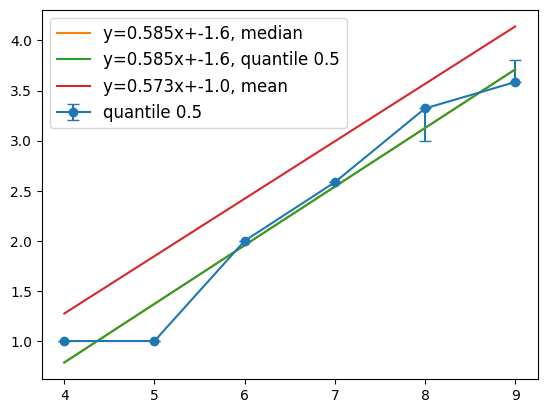

In [70]:
k1 = 4
k2 = 9

A = full_data_random_walk(k1,k2, 1250, 1,0.5, 1/3,2/3)

Size = np.linspace(k1,k2, k2-k1+1)
linear_regression(0.5,Size,A)